In [1]:
run instagram_poster

In [2]:
import re
import yaml
from datetime import date
from markdown2 import markdown
from mdplain import plain
from pathlib import Path

places = []
taste_labels = ["Do Not Recommend", "Something Going For It", "Good", "Phenomenal"]
taste_labels_short = ["dnr", "sgfi", "good", "phenomenal"]

def rating_to_formatting(rating, rating_labels):
    return rating_labels[rating]
def rating_html(rating, rating_labels):
    return "&nbsp;".join(
        [
            f'<span style="color: {color if rating == ix else faded_color}" aria-hidden="{"false" if rating == ix else "true"}">{label}</span>'
            for ix, (label, color) in enumerate(zip(rating_labels, rating_colors))
        ]
    )
def suffix(d):
    return "th" if 11 <= d <= 13 else {1: "st", 2: "nd", 3: "rd"}.get(d % 10, "th")
def custom_strftime(format_, t):
    return t.strftime(format_).replace("{S}", str(t.day) + suffix(t.day))
def format_visited(visited):
    return custom_strftime("{S} %B %Y", visited)
def format_blurb(md):
    return " ".join(plain(re.sub(r"\s+", " ", md.strip())).split(" ")[:50]) + "..."
    
for place_md in Path("../places").glob("*.md"):
    try: 
        slug = place_md.parts[-1][:-3]
        relative_url = f"/places/{slug}/"
        with open(place_md) as f:
            _, frontmatter, md = f.read().split("---", 2)
        meta = yaml.load(frontmatter, Loader=yaml.Loader)
        meta["url"] = relative_url
        meta["slug"] = slug
        visited = date.fromisoformat(meta["visited"])
        meta["visited_display"] = format_visited(visited)
        meta["review_age"] = (date.today() - visited).days
        meta["taste_label"] = rating_to_formatting(meta["taste"], taste_labels)
        meta["taste_label_short"] = rating_to_formatting(meta["taste"], taste_labels_short)
        meta["blurb"] = format_blurb(md)

        places.append(meta)

    except Exception as e:
        print(place_md.name, e)


In [3]:
def toggle_instagram_published(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    pattern = r'(instagram_published:\s*)(True|False)'

    def toggle_match(match):
        current_value = match.group(2)
        new_value = 'False' if current_value == 'True' else 'True'
        return match.group(1) + new_value 

    new_content, n = re.subn(pattern, toggle_match, content)
    if n > 0:
        with open(file_path, 'w') as file:
            file.write(new_content)
    
    

In [6]:
places = sorted(places, key=lambda x: x['review_age'])
places = [p for p in places if p['instagram_published'] is False]
places = [p for p in places if p['name'] != "Fiji Airways"]
places_to_update = places[:1]
[p['name'] for p in places_to_update]

['Mensho Tokyo SF']

In [7]:
credentials_file_path = 'credentials.json'
bot = InstagramBot(credentials_file_path)
bot.login()

Message: 
Stacktrace:
#0 0x5f97a9c402da <unknown>
#1 0x5f97a990e200 <unknown>
#2 0x5f97a995daa2 <unknown>
#3 0x5f97a995dd41 <unknown>
#4 0x5f97a99a3964 <unknown>
#5 0x5f97a99828fd <unknown>
#6 0x5f97a99a0dfd <unknown>
#7 0x5f97a9982673 <unknown>
#8 0x5f97a9950473 <unknown>
#9 0x5f97a995147e <unknown>
#10 0x5f97a9c070db <unknown>
#11 0x5f97a9c0b071 <unknown>
#12 0x5f97a9bf39d5 <unknown>
#13 0x5f97a9c0bbf2 <unknown>
#14 0x5f97a9bd8b6f <unknown>
#15 0x5f97a9c2f248 <unknown>
#16 0x5f97a9c2f417 <unknown>
#17 0x5f97a9c3f0cc <unknown>
#18 0x76a247094ac3 <unknown>



In [9]:
MINUTE = 60

In [ ]:
for place in places_to_update:
    try:
        bot.upload_post(place)
        filepath = Path(".." + place['url'][:-1] + ".md")
        toggle_instagram_published(filepath)
    except Exception as e:
        print(e)
    sleep_time = MINUTE * (2 + random())
    print(f"sleeping for {sleep_time / MINUTE} minutes")
    sleep(sleep_time)

In [60]:
# credentials_file_path = 'credentials.json'
# bot = InstagramBot(credentials_file_path)
# bot.login()
# for place in places_to_update:
#     bot.upload_post(place)
#     filepath = Path(".." + place['url'][:-1] + ".md")
#     toggle_instagram_published(filepath)
#     sleep(120 * random())


In [3]:
places = sorted(places, key=lambda x: -x['review_age'])

In [43]:
values = [p['taste'] for p in places]

In [104]:
df = pd.DataFrame(values, columns=['value'])
window = 50

df.index.name = "n_reviews"
df['prop_0'] = 0.0
df['prop_1'] = 0.0
df['prop_2'] = 0.0
df['prop_3'] = 0.0

for i in range(len(df)):
    counts = df.loc[i-window:i, 'value'].value_counts(normalize=True)
    df.loc[i, 'prop_0'] = counts.get(0, 0)
    df.loc[i, 'prop_1'] = counts.get(1, 0)
    df.loc[i, 'prop_2'] = counts.get(2, 0)
    df.loc[i, 'prop_3'] = counts.get(3, 0)

df.index += 1
df = df.reset_index()

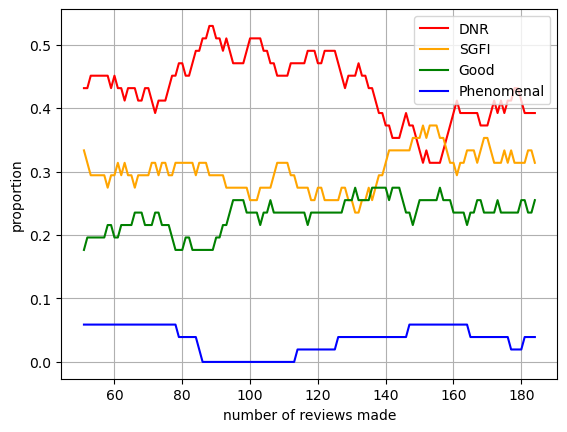

In [105]:
plot_df = df.iloc[window:]
plt.plot(plot_df.n_reviews, plot_df.prop_0, color="red", label="DNR")
plt.plot(plot_df.n_reviews, plot_df.prop_1, color="orange", label="SGFI")
plt.plot(plot_df.n_reviews, plot_df.prop_2, color="green", label="Good")
plt.plot(plot_df.n_reviews, plot_df.prop_3, color="blue", label="Phenomenal")

plt.ylabel("proportion")
plt.xlabel("number of reviews made")
plt.legend()
plt.grid()

In [63]:
import matplotlib.pyplot as plt